In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'three_body'
seed = 0

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[],
                'dynamic_potential_list':['point_source','point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':10}, {'M':10}, {'M':10}],
                'seed':seed,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    print(init_params)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

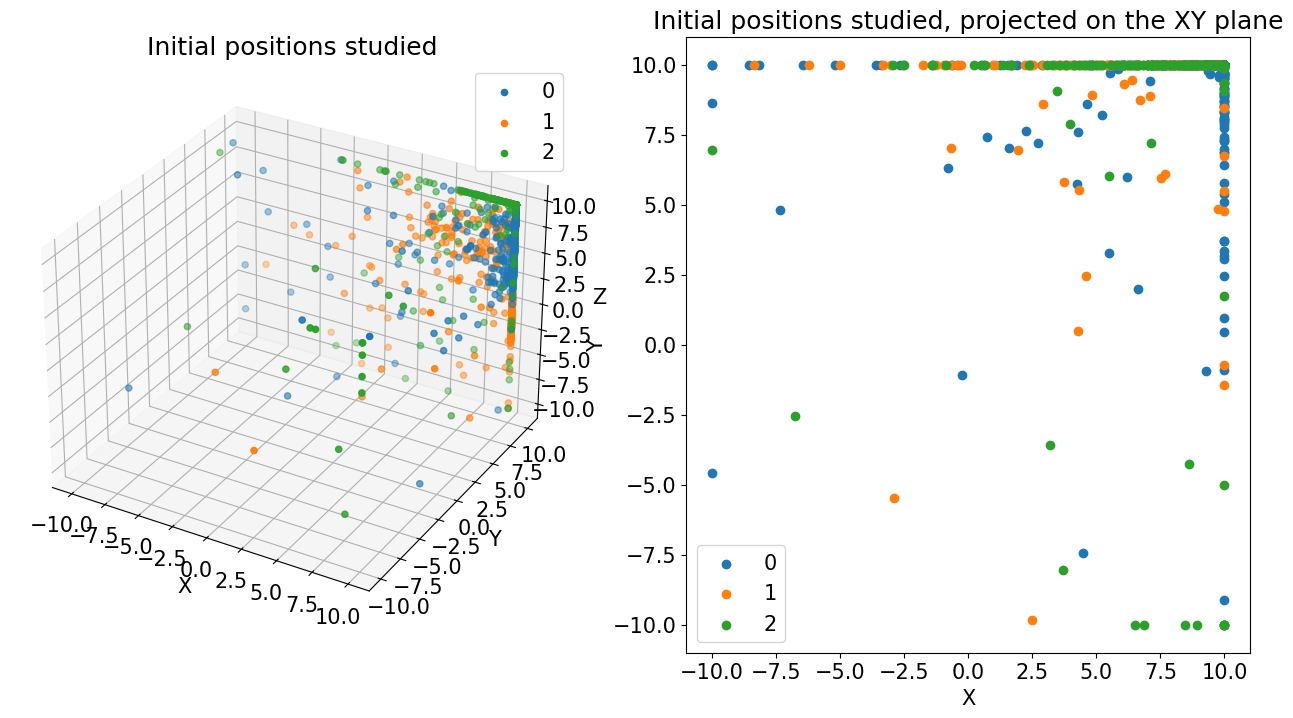

In [5]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [6]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) / env.high for agent in range(env.num_agents)}

{0: np.float64(0.014272708914965848), 1: np.float64(0.010217889335177461), 2: np.float64(0.01301735147187778)}
{0: array([1.        , 0.96751232, 0.42491412, 0.0222166 , 0.10578576,
       0.11009701]), 1: array([ 1.        ,  1.        ,  0.63714218, -0.10155243, -0.12728205,
       -0.0411455 ]), 2: array([1.        , 1.        , 1.        , 0.07303818, 0.01742045,
       0.02619527])}


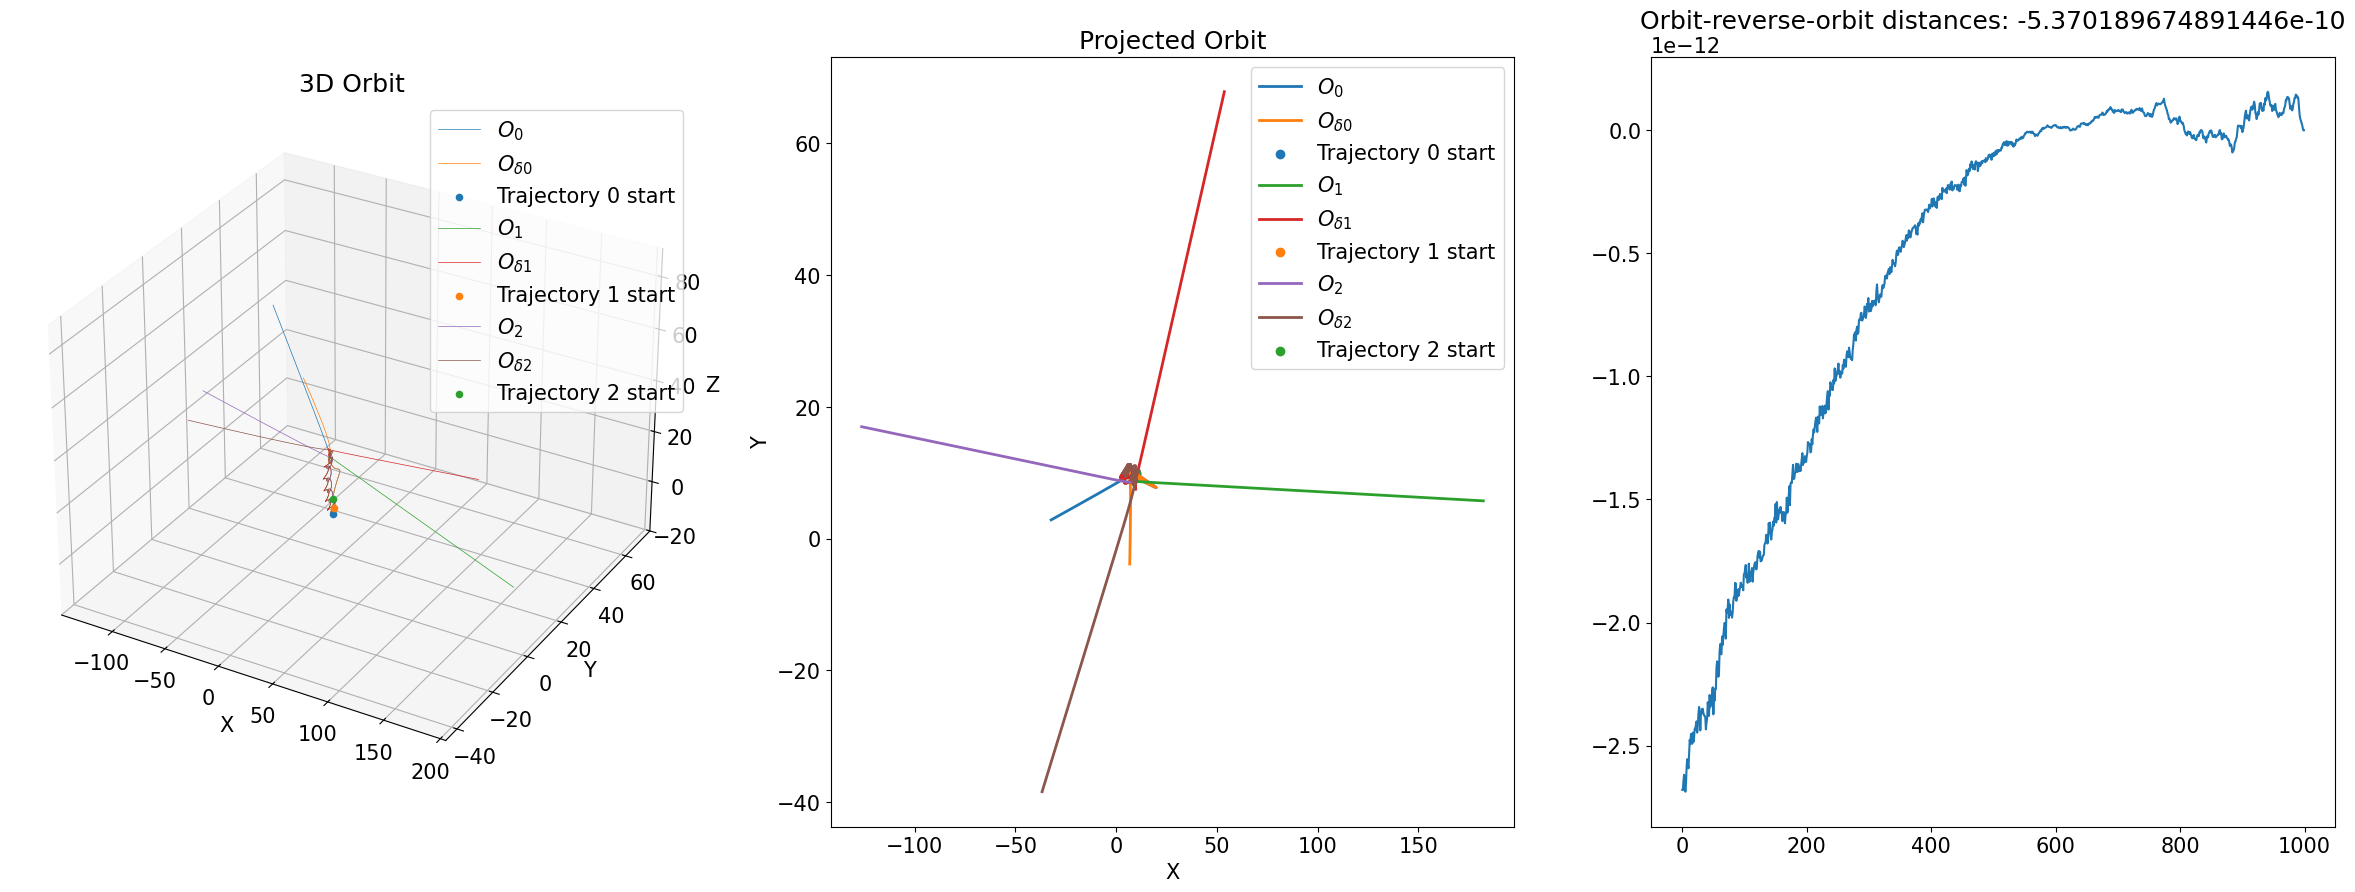

In [7]:
plot_from_init(result_to_init(0))

{0: np.float64(0.014139330248763009), 1: np.float64(0.013942650186737418), 2: np.float64(0.013714373903703218)}
{0: array([ 1.        ,  1.        ,  0.90469017,  0.01246485, -0.13317424,
       -0.0627166 ]), 1: array([ 1.        ,  1.        , -0.07370728, -0.06637274, -0.03131786,
       -0.01716724]), 2: array([ 1.        ,  1.        ,  1.        , -0.05187801,  0.2018059 ,
        0.16002944])}


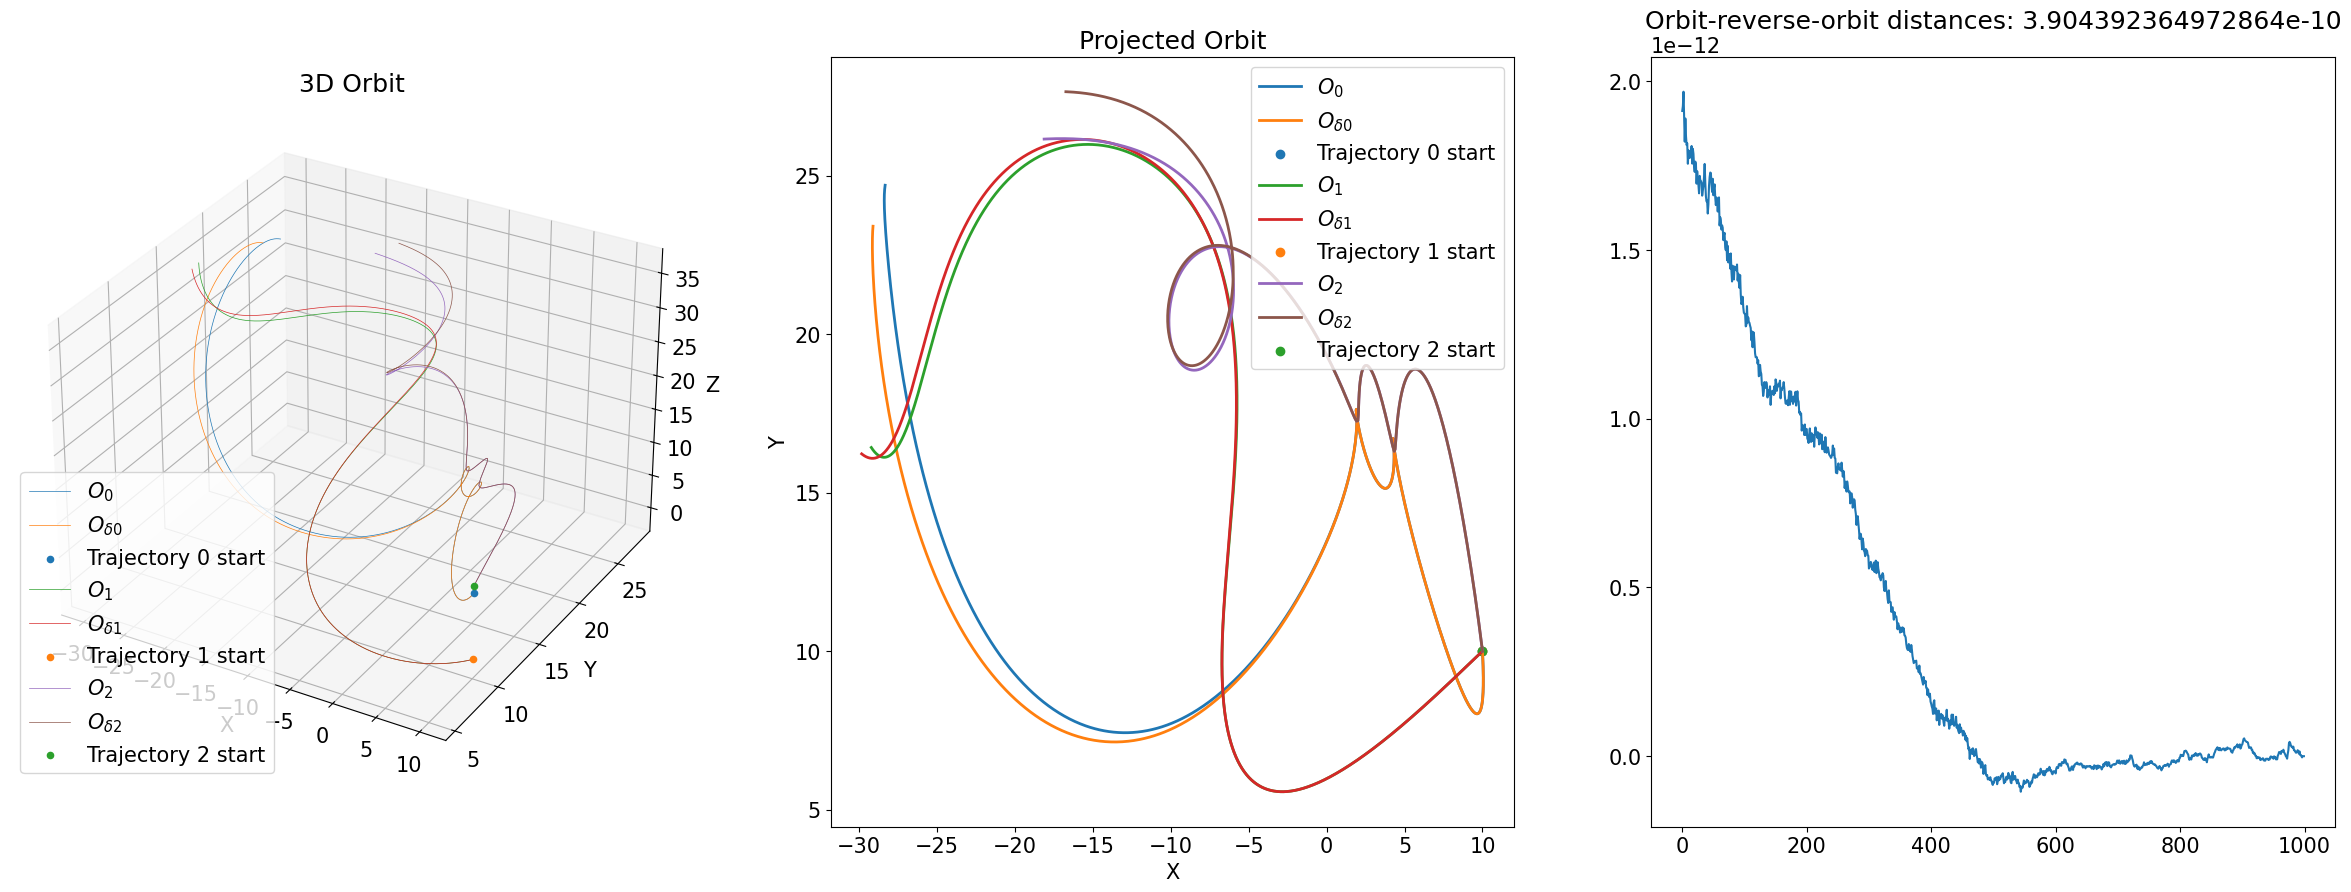

In [8]:
plot_from_init(result_to_init(1))

{0: np.float64(0.01804381768105985), 1: np.float64(0.019457660436455942), 2: np.float64(0.01681737248639128)}
{0: array([ 1.        ,  1.        ,  0.34280353, -0.03703026,  0.08700527,
       -0.04159645]), 1: array([0.94517078, 1.        , 0.66600513, 0.03355879, 0.02225691,
       0.03567713]), 2: array([ 1.        ,  1.        ,  1.        ,  0.02586739, -0.12000749,
       -0.0575287 ])}


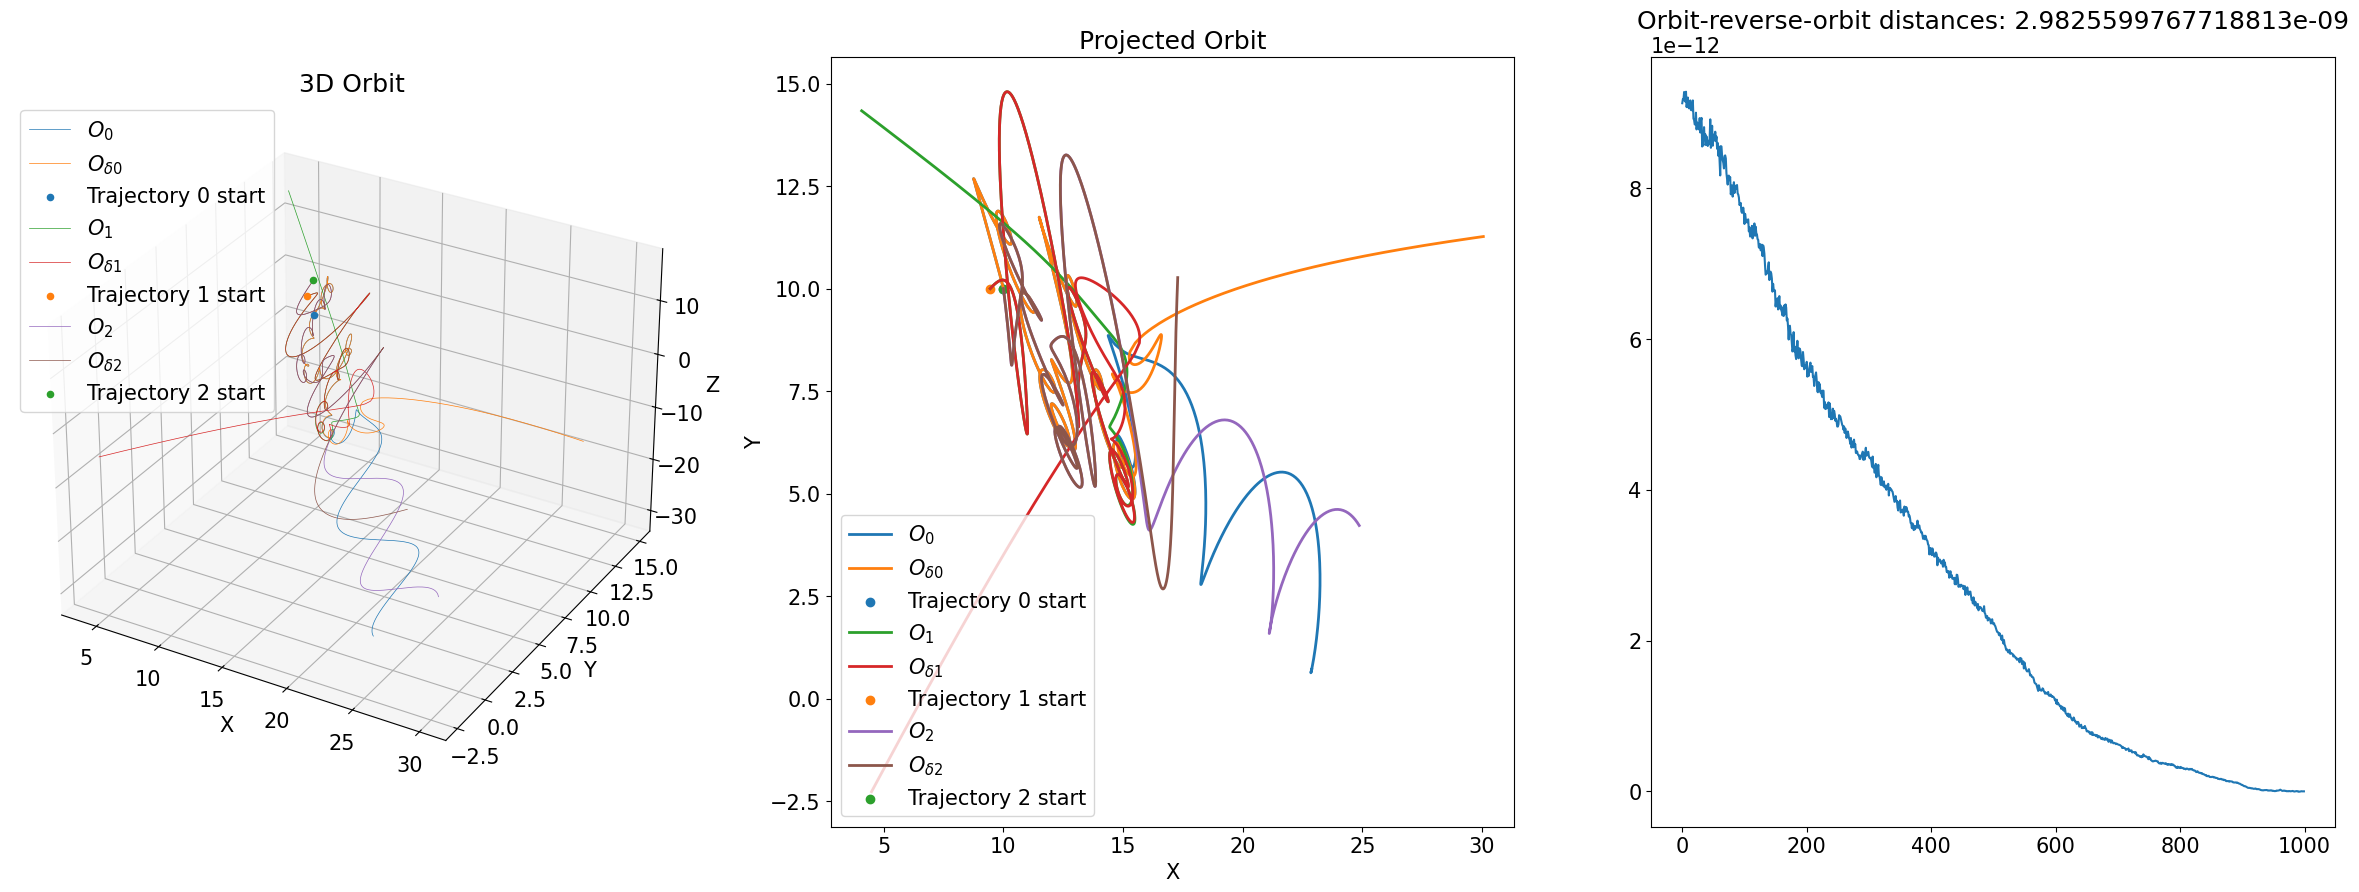

In [9]:
plot_from_init(result_to_init(5))

{0: np.float64(0.014197971446238354), 1: np.float64(0.017501528962401737), 2: np.float64(0.013754852973629751)}
{0: array([ 1.        ,  1.        ,  0.82471752, -0.0632344 , -0.1591718 ,
       -0.11054508]), 1: array([ 1.        ,  1.        , -0.03028885,  0.00692462,  0.01399626,
       -0.0596087 ]), 2: array([ 1.        ,  1.        ,  1.        , -0.04865407,  0.00727461,
        0.11873086])}


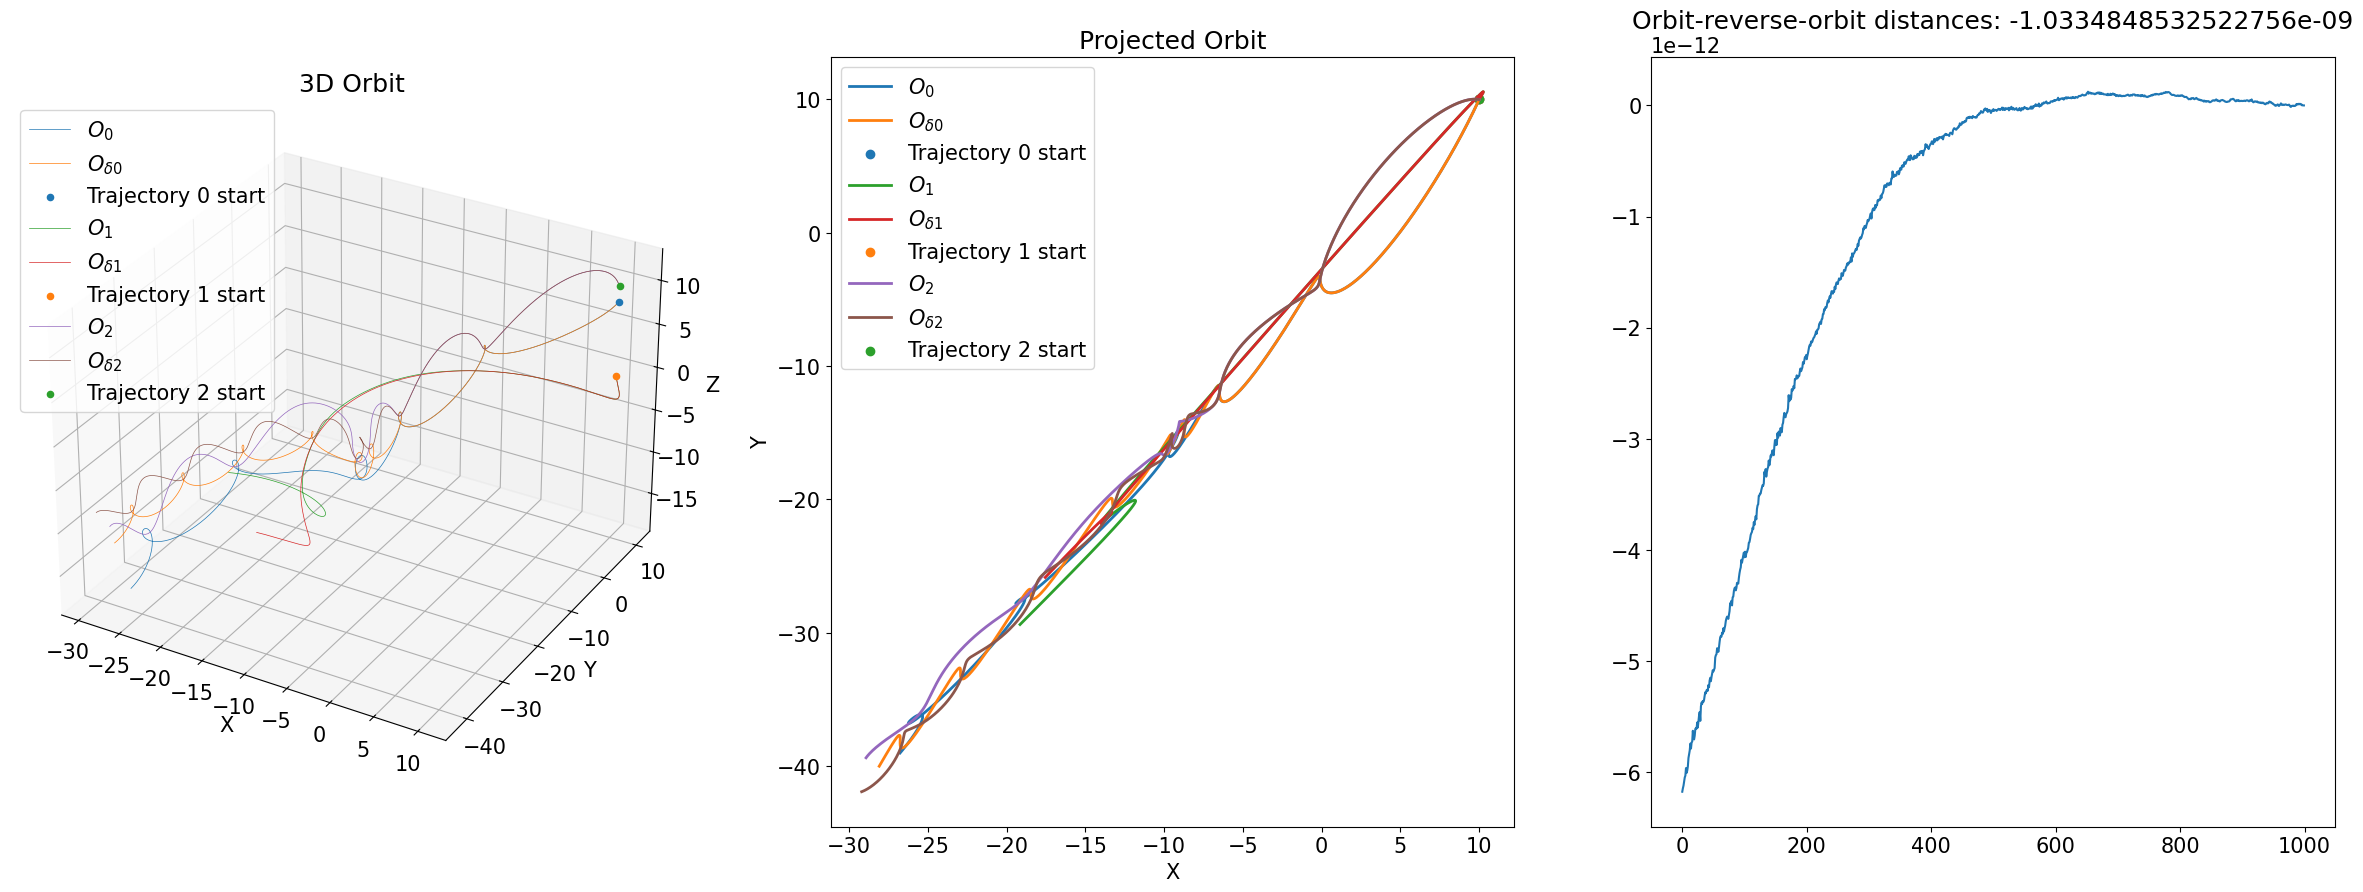

In [10]:
plot_from_init(result_to_init(3))